In [1]:
import torch

print(torch.cuda.is_available())

True


In [2]:
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from torch.autograd import Function

In [3]:
#the transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Define the DenseNet model
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  

c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Define the data loaders
train_dataset = ImageFolder(
    "G:\\ProjectsDocs\\memes\\memes_dataset\\train", transform=transform)
test_dataset = ImageFolder(
    "G:\\ProjectsDocs\\memes\\memes_dataset\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Training loop
num_epochs = 20
best_accuracy = 0.0
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    print(report)
    print(conf_matrix)

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.3201, Accuracy: 0.9057, Precision: 0.9060, Recall: 0.9057, F1-Score: 0.9055
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        86
           1       0.91      0.88      0.90        73

    accuracy                           0.91       159
   macro avg       0.91      0.90      0.90       159
weighted avg       0.91      0.91      0.91       159

[[80  6]
 [ 9 64]]
Epoch 2, Loss: 0.2048, Accuracy: 0.9119, Precision: 0.9126, Recall: 0.9119, F1-Score: 0.9117
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        86
           1       0.93      0.88      0.90        73

    accuracy                           0.91       159
   macro avg       0.91      0.91      0.91       159
weighted avg       0.91      0.91      0.91       159

[[81  5]
 [ 9 64]]
Epoch 3, Loss: 0.1860, Accuracy: 0.9623, Precision: 0.9636, Recall: 0.9623, F1-Score: 0.9623
              precision    re

In [8]:
# Define the image preprocessing function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

In [9]:
# Define the image classification function
def classify_image(model, image_tensor, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()
        return 'Meme' if class_idx == 0 else 'Not Meme'

# Define the function to display the image
def display_image(image_path, label):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


360_F_516304631_6stJvborNsJ0x1c0PfznMgJPGQbJ5hFg.jpg: Meme


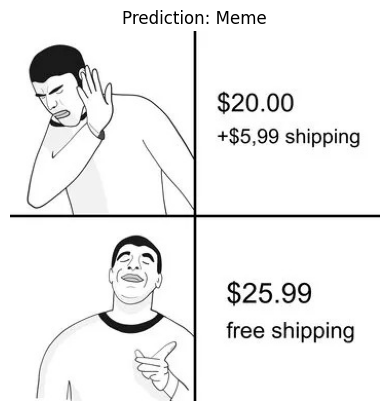

7f1e6d18f35ab98b02f876f580c1f5fb.jpg: Meme


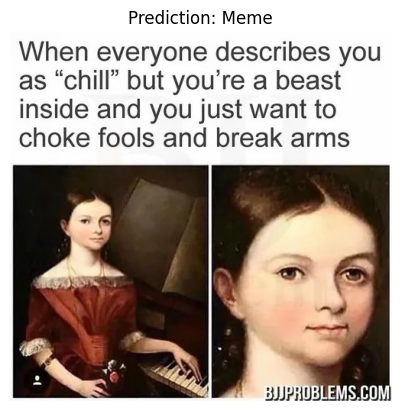

8r06r1.jpg: Meme


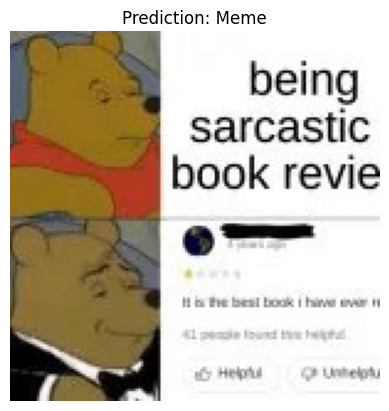

et9cmz0wny1d1.jpg: Meme


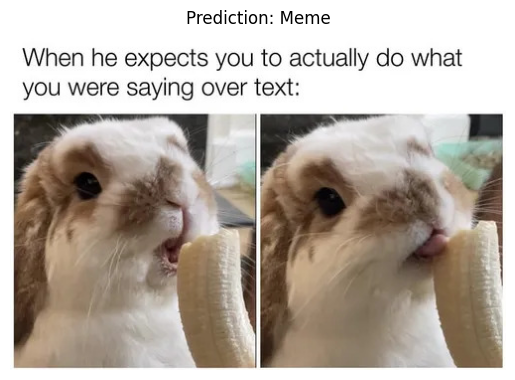

funny-meme-pictures-ppzthb74p3b686b9.jpg: Meme


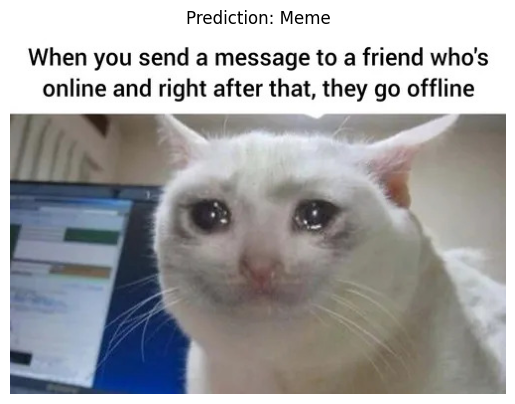

happy-rescued-sloth.jpg: Not Meme


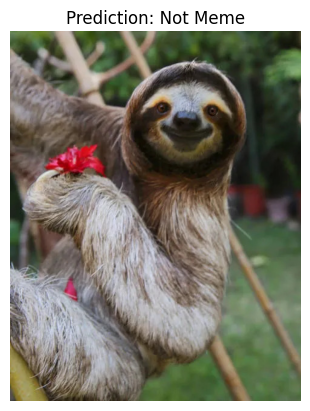

laughing-together.jpg: Not Meme


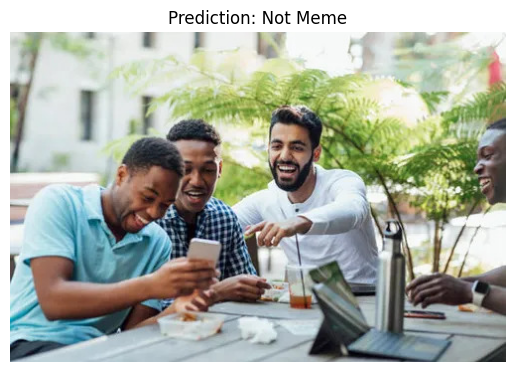

silly-cat.jpg: Not Meme


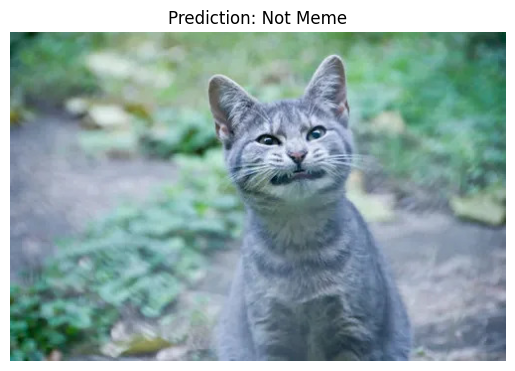

In [10]:
# Function to classify and display all images in a folder
def classify_and_display_images_in_folder(model, folder_path, device):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            image_tensor = preprocess_image(image_path)
            label = classify_image(model, image_tensor, device)
            print(f'{filename}: {label}')
            display_image(image_path, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 2)  # Adjust the final layer for binary classification (Meme/Not Meme)

# Load your custom-trained model weights
model_weights_path = 'best_model.pth'
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Replace with the path to your image folder
folder_path = 'G:\Projectsdocs\memes\image_folder'

classify_and_display_images_in_folder(model, folder_path, device)

In [49]:
# Define the image preprocessing function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Hook for gradients
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None
        self.gradients = None

    def hook_fn(self, module, input, output):
        self.features = output
        output.register_hook(self.save_grads)

    def save_grads(self, grads):
        self.gradients = grads

    def remove(self):
        self.hook.remove()


In [62]:
def generate_gradcam(model, input_tensor, device, target_layer):
    model.eval()

    # Hook the feature and gradient for the target layer
    features_hook = SaveFeatures(target_layer)

    # Forward pass
    output = model(input_tensor.to(device))
    target_class = output.argmax(dim=1).item()

    # Backward pass to get the gradients
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Get the feature maps and gradients
    gradients = features_hook.gradients[0].cpu().data.numpy()
    features = features_hook.features[0].cpu().data.numpy()

    # Compute the Grad-CAM
    weights = np.mean(gradients, axis=(1, 2))
    gradcam_map = np.sum(weights[:, np.newaxis, np.newaxis] * features, axis=0)
    gradcam_map = np.maximum(gradcam_map, 0)
    gradcam_map = cv2.resize(gradcam_map, (input_tensor.shape[3], input_tensor.shape[2]))
    gradcam_map = gradcam_map - np.min(gradcam_map)
    gradcam_map = gradcam_map / np.max(gradcam_map)

    # Visualize the Grad-CAM output
    img = input_tensor.cpu().numpy()[0].transpose((1, 2, 0))
    img = np.float32(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)

    # Adjust transparency
    alpha = 0.01  # Make the heatmap more transparent
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = superimposed_img / np.max(superimposed_img)

    return superimposed_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


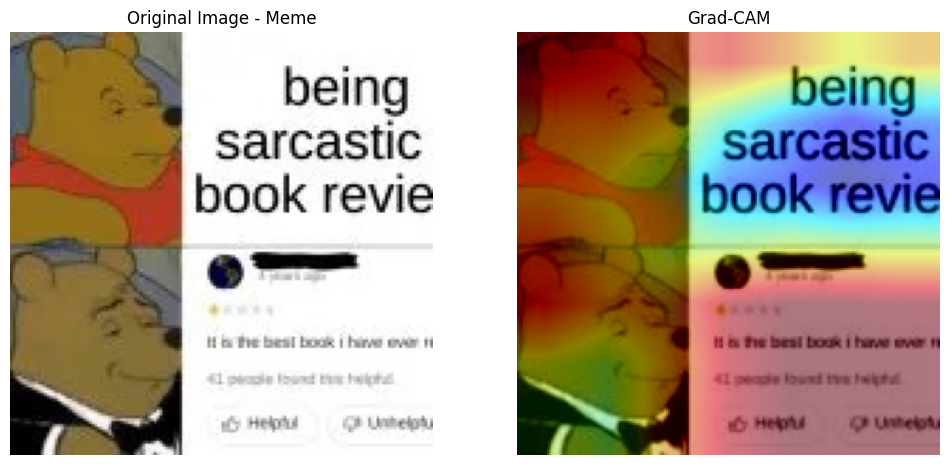

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


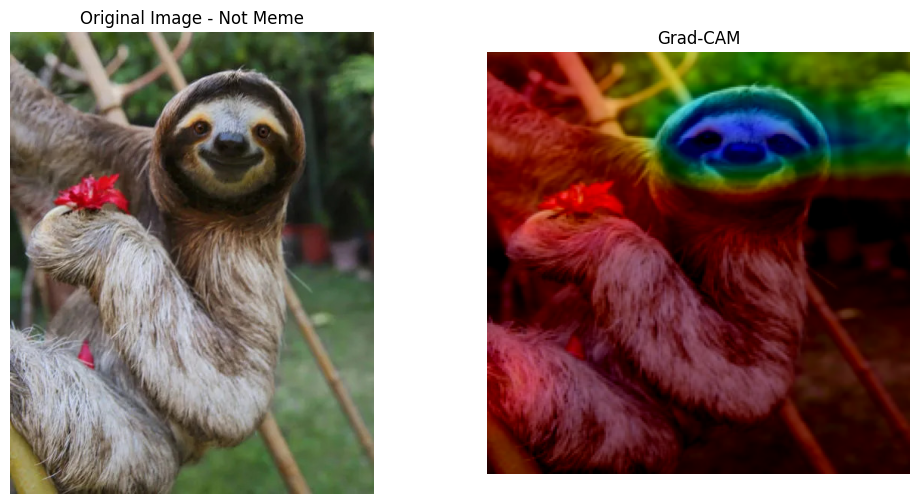

In [71]:
sample_image_path1 = 'G:\Projectsdocs\memes\image_folder\8r06r1.jpg'
sample_input1_tensor = preprocess_image(sample_image_path1)

# The target layer to visualize Grad-CAM for DenseNet
target_layer = model.features.denseblock4

gradcam_img1 = generate_gradcam(model, sample_input1_tensor, device, target_layer)

# original image for display
original_img1 = Image.open(sample_image_path1).convert('RGB')

# the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img1)
plt.title('Original Image - Meme')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img1)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()


sample_image_path2 = r'G:\Projectsdocs\memes\image_folder\happy-rescued-sloth.jpg'
sample_input2_tensor = preprocess_image(sample_image_path2)
gradcam_img2 = generate_gradcam(model, sample_input2_tensor, device, target_layer)
original_img2 = Image.open(sample_image_path2).convert('RGB')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img2)
plt.title('Original Image - Not Meme')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img2)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()